# Thermochemical benchmark: atomisation of closed shell molecules with core correlation

Bak et al., [doi:10.1063/1.1357225](https://doi.org/10.1063/1.1357225) and [doi:10.1063/1.481544](https://doi.org/10.1063/1.481544)

In [1]:
import pymolpro
import pandas as pd

In [2]:
backend = 'local'  # If preferred, change this to one of the backends in your ~/.sjef/molpro/backends.xml that is ssh-accessible
project_name = 'Bak2000_atomisations'
parallel = None  # how many jobs to run at once

In [3]:
methods = { "HF": ["hf","uhf"], "MP2": ["mp2","ump2"], "CCSD": ["ccsd","uccsd"], }
bases = ['cc-pCVDZ','cc-pCVTZ','cc-pCVQZ','cc-pCV5Z']

In [4]:
db = pymolpro.database.library("Bak2000_atomisations")

In [5]:
results = {}
for method in methods:
    results[method] = {}
    for basis in bases:
        results[method][basis] = pymolpro.database.run(db, methods[method], basis, location=project_name, backend=backend,
                                                       preamble="core,small", parallel=parallel)

In [6]:
extrapolations = {}
if 'cc-pCVDZ' in bases and 'cc-pCVTZ' in bases:
    extrapolations["cc-pCV[23]Z"] = {'x': 2, 'first': 'cc-pCVDZ', 'second': 'cc-pCVTZ'}
if 'cc-pCVTZ' in bases and 'cc-pCVQZ' in bases:
    extrapolations["cc-pCV[34]Z"] = {'x': 3, 'first': 'cc-pCVTZ', 'second': 'cc-pCVQZ'}
if 'cc-pCVQZ' in bases and 'cc-pCV5Z' in bases:
    extrapolations["cc-pCV[45]Z"] = {'x': 4, 'first': 'cc-pCVQZ', 'second': 'cc-pCV5Z'}

for extr in extrapolations:
    x = extrapolations[extr]['x']
    xbas = extrapolations[extr]['first']
    xpbas = extrapolations[extr]['second']
    for method in methods:
        results[method][extr] = pymolpro.database.basis_extrapolate(
            [results[method][xbas], results[method][xpbas]],
            [results['HF'][xbas], results['HF'][xpbas]],
            [x, x + 1]
        )
    bases.append(extr) if extr not in bases else ""


In [7]:
tokj = 2625.49963948
pd.set_option('display.precision', 2)
method_errors = pymolpro.database.compare([results[method]['cc-pCV5Z'] for method in methods], db.reference_results())[
                    'reaction statistics'] * tokj
method_errors

,UHF,UMP2,UCCSD
,cc-pCV5Z,cc-pCV5Z,cc-pCV5Z
mean,-405.05,21.79,-34.61
stdev,143.84,30.40,18.76
meanabs,405.05,29.43,34.61
maxabs,598.79,99.26,69.02


In [8]:
pd.set_option('display.precision', 2)
basis_errors = pymolpro.database.compare([results['CCSD'][basis] for basis in bases], db.reference_results())[
                   'reaction statistics'] * tokj
basis_errors

UCCSD                                                     \
        cc-pCVDZ cc-pCVTZ cc-pCVQZ cc-pCV5Z cc-pCV[23]Z cc-pCV[34]Z   
mean     -121.40   -59.96   -40.92   -34.61      -43.84      -28.78   
stdev      45.18    27.14    20.78    18.76       24.36       16.89   
meanabs   121.40    59.96    40.92    34.61       43.91       28.83   
maxabs    177.81   107.34    78.23    69.02       91.02       58.93   

                     
        cc-pCV[45]Z  
mean         -28.48  
stdev         16.43  
meanabs       28.50  
maxabs        58.55

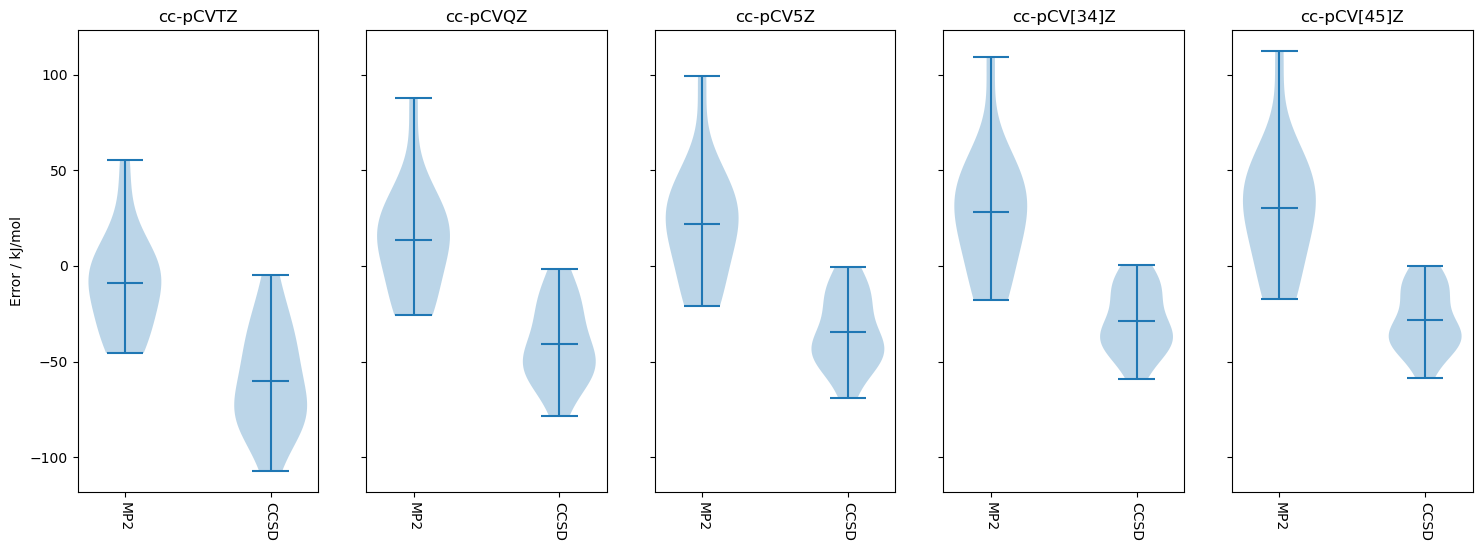

In [9]:
import matplotlib.pyplot as plt

methods_pruned = [method for method in methods if method != 'HF']
bases_pruned = ['cc-pCVTZ', 'cc-pCVQZ', 'cc-pCV5Z', 'cc-pCV[34]Z', 'cc-pCV[45]Z']
fig, panes = plt.subplots(nrows=1, ncols=len(bases_pruned), sharey=True, figsize=(18, 6))

for pane in range(len(bases_pruned)):
    data = []
    for method in methods_pruned:
        data.append(
            pymolpro.database.compare(results[method][bases_pruned[pane]],
                                      db.reference_results())['reaction energy errors'].to_numpy()[:, 0] * tokj
        )
    panes[pane].violinplot(data, showmeans=True, showextrema=True, vert=True, bw_method='silverman')
    panes[pane].set_xticks(range(1, len(methods_pruned) + 1), labels=methods_pruned, rotation=-90)
    panes[pane].set_title(bases_pruned[pane])
panes[0].set_ylabel('Error / kJ/mol')
plt.savefig(project_name + ".violin.pdf")

In [10]:
with open(project_name + '.tex', 'w') as tf:
    tf.write('\\def\\toprule{\\hline\\hline}\n\\def\\midrule{\\hline}\n\\def\\bottomrule{\\hline\\hline}')
    tf.write(df_exp_reaction_meanerror.style.to_latex())
    tf.write(df_exp_reaction_std.style.to_latex())
    tf.write(df_exp_reaction_meanabserror.style.to_latex())
    tf.write(df_exp_reaction_maxerror.style.to_latex())

NameError: name 'df_exp_reaction_meanerror' is not defined